>https://www.youtube.com/watch?v=9aYuQmMJvjA

# Convnet Intro - Convolutional Neural Networks (p. 5)

- <mark>Convolutional Neural Networks (CNN)</mark> mainly used for image tasks; but it's out-performing ***recurrent neural networks*** so it's good in training **sequential** types of data
- In image tasks, it tasks in images in it's raw form - even 3D images. **NO** need to flatten or adjust.
- <mark>Convolutions</mark>: goal is to locate features of a image through its pixels
- Image as input is **called** a <mark>window</mark> or <mark>"X by Y" (dimension) "Convolution Kernel"</mark>
- Convolution first finds edges, curves, then searches a more complex one level up like a shape (multiple edges or curves) and so on...

![alt text](img/ConvolutionConcept.png)

- after convolution, then <mark>pooling</mark>
- <mark>Max Pooling</mark>: algorithm that takes maximum value generated by the convolution process in every window generated, **basically simplifying the image more and more**
- Every level up (layer) of convolution **INCREASES** kernel/window dimension
- underestimated step not in tutorials is the **Preprocessing** step of datasets. this is to prepare it for the neural network and realistically it'll always take a long time.

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

**Cats v Dogs Dataset found here:** https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

In [3]:
REBUILD_DATA = False

class DogsVSCats():
    # we're going to make images 50 x 50
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                # handle empty images
                except Exception as e:
                    pass
                    #print(str(e))
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("\nCats: ", self.catcount)
        print("\nDogs: ", self.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [4]:
np.eye(10)[7]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [5]:
training_data = np.load("training_data.npy", allow_pickle = True)

In [6]:
print(len(training_data))

24946


In [7]:
print(training_data[1])

[array([[ 17,   4,  14, ...,  24, 110,  67],
       [  6,  15,  20, ...,  26,  24,  29],
       [ 15,   6,   8, ...,  45,  23,  16],
       ...,
       [ 25,  25, 114, ...,  30,  60,  47],
       [  5,  15, 116, ...,  59,  44,  31],
       [ 10,  33, 109, ...,  32,  27,  52]], dtype=uint8)
 array([1., 0.])]


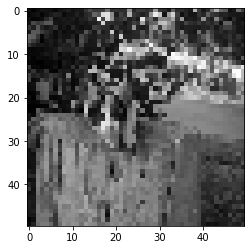

In [8]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap = "gray")
plt.show()

In [9]:
training_data[1][1]

array([1., 0.])

>https://www.youtube.com/watch?v=1gQR24B3ISE

# Training Convnet - Convolutional Neural Networks (pt. 6)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)
        # run forward pass once (convs(x)) to determine _to_linear vars

        # fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        print(x[0].shape)
        # here is to flatten? 
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    # forward pass
    def forward(self, x):
        x = self.convs(x) # pass through all conv layers
        x = x.view(-1, self._to_linear) # flatten
        x = F.relu(self.fc1(x)) # pass through 1st fully connected layer
        x = self.fc2(x) # 2nd
        return F.softmax(x, dim = 1) # activaton (softmax)

net = Net()

torch.Size([128, 2, 2])


In [11]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

# separate x's and y's
x = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
x = x/255.0 # scaling the pixel values
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(x) * VAL_PCT)
print(val_size)

2494


In [12]:
train_x = x[:-val_size]
train_y = y[:-val_size]

test_x = x[-val_size:]
test_y = y[-val_size:]

print(len(train_x))
print(len(test_x))

22452
2494


In [13]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_x), BATCH_SIZE)):
        # print(i, i + BATCH_SIZE)

        batch_x = train_x[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()
        outputs = net(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

print(loss)

  7%|▋         | 15/225 [00:03<00:53,  3.96it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
  9%|▉         | 20/225 [00:05<00:51,  4.01it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 23%|██▎       | 52/225 [00:13<00:44,  3.89it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 25%|██▌       | 57/225 [00:14<00:46,  3.58it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 26%|██▌       | 59/225 [00:15<00:46,  3.54it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 30%|██▉       | 67/225 [00:17<00:45,  3.48it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 31%|███       | 70/225 [00:18<00:43,  3.54it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 32%|███▏      | 73/225 [00:19<00:43,  3.46it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 34%|███▍      | 77/225 [00:20<00:43,  3.42it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 36%|███▌      | 81/225 [00:21<00:40,  3.55it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 40%|████      | 91/225 [00:24<00:40,  3

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_x))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_x[i].view(-1, 1, 50, 50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3) * 100, "%")

2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 69%|██████▊   | 1710/2494 [00:05<00:02, 318.56it/s]
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 70%|██████▉   | 1744/2494 [00:05<00:02, 323.10it/s]
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])

>https://www.youtube.com/watch?v=6gk7giKER6s

# Computing on the GPU - Deep Learning and Neural Networks (pt. 7)


In [15]:
train(Net)

NameError: name 'train' is not defined

In [16]:
test(Net)

NameError: name 'test' is not defined